# Yelp Reviews on Portland's Cafés | Topic Modeling

In [98]:
# import data munging modules
from pprint import pprint
import pandas as pd
import numpy as np

# import visualization modules
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pprint import pprint
import scattertext as st
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from wordcloud import WordCloud, STOPWORDS
import IPython
from IPython.display import IFrame
import stylecloud
sns.set()

# import preprocessing modules
import spacy
import re
import string
from spacy import displacy
from collections import Counter
from nltk.stem import PorterStemmer
from spacy.symbols import amod
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize

# import topic modeling modules
from sklearn.decomposition import NMF
from gensim import corpora, models, similarities, matutils
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# nltk downloads
nltk.download('punkt', quiet=True, raise_on_error=True)
nltk.download('wordnet', quiet=True, raise_on_error=True)
nltk.download('stopwords', quiet=True, raise_on_error=True)
nltk.download('tagsets', quiet=True, raise_on_error=True)
nltk.download('averaged_perceptron_tagger', quiet=True, raise_on_error=True)

True

## EDA

In [2]:
cafes_portland = pd.read_pickle('cafes_portland.pickle')

In [3]:
reviews_cafes_portland = pd.read_pickle('reviews_cafes_portland.pickle')

In [4]:
cafes_portland.shape

(1218, 11)

In [5]:
reviews_cafes_portland.shape

(128770, 8)

In [6]:
reviews_cafes_portland.head()

,review_id,business_id,stars,useful,funny,cool,text,date
44,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,"Dont bother going to voodoo, just come here in...",2016-09-18 17:06:01
45,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,Incredible donuts. Sometimes you have to go ea...,2017-08-07 19:34:13
56,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,4,4,4,"""Even the mad Captain Ahab is touched by Starb...",2017-12-02 19:41:59
65,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,1,0,1,It's crazy how establishments on the west coas...,2011-02-13 16:38:09
67,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,0,0,0,"5 stars for the location, it's absolutely wond...",2018-04-27 18:41:52


In [7]:
# check distribution of stars across reviews
reviews_cafes_portland.stars.value_counts(normalize=True)

5.0    0.535311
4.0    0.240405
3.0    0.095775
1.0    0.065233
2.0    0.063276
Name: stars, dtype: float64

----

Five and four stars make up for ca. **78% of all reviews**. This could be due to the fact that Portland is well-known for its great coffee, hence pushing up all reviews - or due to a potential behavioral trend by users to mostly share a review when it's positive.

----

In [8]:
reviews_cafes_portland['review_length'] = reviews_cafes_portland.text.map(len)

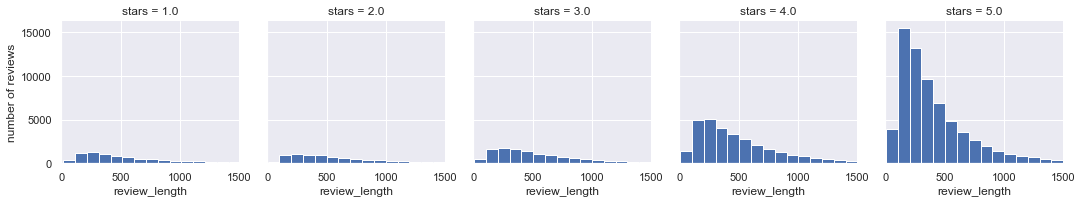

In [9]:
# check distributions of review lengths
ax = sns.FacetGrid(data=reviews_cafes_portland, col='stars', xlim=(0, 1500)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='number of reviews');

The distributions of *review_length* for 1, 2 and 3 stars reviews is fairly similar. Instead, 4 and 5 stars reviews have a more right-skewed distribution, with the 5 stars one presenting a larger skewness and taller peak.

In [10]:
# avg review length by star
stars_list = [1,2,3,4,5]

for i in stars_list:
    avg_review_length = round(reviews_cafes_portland[reviews_cafes_portland['stars']==i]['review_length'].mean(),2)
    print('Average review length for {} stars reviews: {}\t'.format(i, avg_review_length))
print(' ')
print('Average review length for all reviews: {}\t'.format(round(reviews_cafes_portland['review_length'].mean(),2)))

Average review length for 1 stars reviews: 636.91	
Average review length for 2 stars reviews: 651.68	
Average review length for 3 stars reviews: 595.45	
Average review length for 4 stars reviews: 526.35	
Average review length for 5 stars reviews: 436.12	
 
Average review length for all reviews: 499.81	


Before any preprocessing step, we can notice that the average review length is ca. 500. Interestingly, the **average review length is higher the lower is the number of stars**. As a hypothesis, this could be due to the fact that, from a behavioral perspective, users tend to share more content when they are dissatisfied with a service.<br/>
In addition, the average length of documents will be useful to know when selecting the best topic modeling technique later in the notebook. 

## Preprocessing

In [11]:
reviews_cafes_portland.shape

(128770, 9)

In [12]:
reviews_cafes_portland.reset_index(inplace = True, drop = True)

In [13]:
reviews_cafes_portland.head()

,review_id,business_id,stars,useful,funny,cool,text,date,review_length
0,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,"Dont bother going to voodoo, just come here in...",2016-09-18 17:06:01,143
1,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,Incredible donuts. Sometimes you have to go ea...,2017-08-07 19:34:13,109
2,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,4,4,4,"""Even the mad Captain Ahab is touched by Starb...",2017-12-02 19:41:59,715
3,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,1,0,1,It's crazy how establishments on the west coas...,2011-02-13 16:38:09,1140
4,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,0,0,0,"5 stars for the location, it's absolutely wond...",2018-04-27 18:41:52,322


### 1. Data Cleaning

In [14]:
# Text preprocessing steps - remove numbers, capital letters and punctuation
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
trail_ws =  lambda x: x.rstrip()

reviews_cafes_portland['text'] = reviews_cafes_portland.text.map(alphanumeric).map(punc_lower).map(trail_ws)
reviews_cafes_portland.head()

,review_id,business_id,stars,useful,funny,cool,text,date,review_length
0,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,dont bother going to voodoo just come here in...,2016-09-18 17:06:01,143
1,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,incredible donuts sometimes you have to go ea...,2017-08-07 19:34:13,109
2,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,4,4,4,even the mad captain ahab is touched by starb...,2017-12-02 19:41:59,715
3,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,1,0,1,it s crazy how establishments on the west coas...,2011-02-13 16:38:09,1140
4,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,0,0,0,stars for the location it s absolutely wond...,2018-04-27 18:41:52,322


In [15]:
reviews_cafes_portland.shape

(128770, 9)

> Section 2 and 3 below are presented as part of the initial data exploration, as the tokenization and lemmatization will be executed within the CountVectorizer or TfidfVectorizer. 

### 2. Tokenize

In [16]:
# initialize spacy model
nlp = spacy.load('en_core_web_sm')

In [17]:
# tokenize reviews
reviews_cafes_portland['spacy_doc'] = list(nlp.pipe(reviews_cafes_portland.text))

In [18]:
reviews_cafes_portland.head()

,review_id,business_id,stars,useful,funny,cool,text,date,review_length,spacy_doc
0,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,dont bother going to voodoo just come here in...,2016-09-18 17:06:01,143,"(do, nt, bother, going, to, voodoo, , just, c..."
1,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,incredible donuts sometimes you have to go ea...,2017-08-07 19:34:13,109,"(incredible, donuts, , sometimes, you, have, ..."
2,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,4,4,4,even the mad captain ahab is touched by starb...,2017-12-02 19:41:59,715,"( , even, the, mad, captain, ahab, is, touched..."
3,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,1,0,1,it s crazy how establishments on the west coas...,2011-02-13 16:38:09,1140,"(it, s, crazy, how, establishments, on, the, w..."
4,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,0,0,0,stars for the location it s absolutely wond...,2018-04-27 18:41:52,322,"( , stars, for, the, location, , it, s, abso..."


In [19]:
reviews_cafes_portland.shape

(128770, 10)

In [20]:
# extract sentiment per review

# define sentiment 
def sentiment(stars_value):
    if stars_value == 4.0 or stars_value == 5.0:
        sentiment = 'positive'
    elif stars_value == 3.0:
        sentiment = 'neutral'
    else:
        sentiment = 'negative'
    return sentiment

# create new col
reviews_cafes_portland['sentiment'] = reviews_cafes_portland['stars'].apply(sentiment)
        
reviews_cafes_portland.head()

,review_id,business_id,stars,useful,funny,cool,text,date,review_length,spacy_doc,sentiment
0,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,dont bother going to voodoo just come here in...,2016-09-18 17:06:01,143,"(do, nt, bother, going, to, voodoo, , just, c...",positive
1,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,incredible donuts sometimes you have to go ea...,2017-08-07 19:34:13,109,"(incredible, donuts, , sometimes, you, have, ...",positive
2,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,4,4,4,even the mad captain ahab is touched by starb...,2017-12-02 19:41:59,715,"( , even, the, mad, captain, ahab, is, touched...",positive
3,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,1,0,1,it s crazy how establishments on the west coas...,2011-02-13 16:38:09,1140,"(it, s, crazy, how, establishments, on, the, w...",positive
4,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,0,0,0,stars for the location it s absolutely wond...,2018-04-27 18:41:52,322,"( , stars, for, the, location, , it, s, abso...",positive


### 3. Lemmatize

Lemmatization tends to be more accurate then stemming. I'll therefore start with this technique, given the fact that the size of my datacet is acceptable.

In [21]:
# lemmatize
nlp_lemma = spacy.load('en_core_web_sm', disable = ['parser','ner'])
reviews_cafes_portland['spacy_doc_lemma'] = reviews_cafes_portland['text'].apply(lambda x: [token.lemma_ for token in nlp_lemma(x)])

In [22]:
reviews_cafes_portland.head()

,review_id,business_id,stars,useful,funny,cool,text,date,review_length,spacy_doc,sentiment,spacy_doc_lemma
0,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,dont bother going to voodoo just come here in...,2016-09-18 17:06:01,143,"(do, nt, bother, going, to, voodoo, , just, c...",positive,"[do, nt, bother, go, to, voodoo, , just, come..."
1,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,incredible donuts sometimes you have to go ea...,2017-08-07 19:34:13,109,"(incredible, donuts, , sometimes, you, have, ...",positive,"[incredible, donut, , sometimes, you, have, t..."
2,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,4,4,4,even the mad captain ahab is touched by starb...,2017-12-02 19:41:59,715,"( , even, the, mad, captain, ahab, is, touched...",positive,"[ , even, the, mad, captain, ahab, be, touch, ..."
3,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,1,0,1,it s crazy how establishments on the west coas...,2011-02-13 16:38:09,1140,"(it, s, crazy, how, establishments, on, the, w...",positive,"[it, s, crazy, how, establishment, on, the, we..."
4,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,0,0,0,stars for the location it s absolutely wond...,2018-04-27 18:41:52,322,"( , stars, for, the, location, , it, s, abso...",positive,"[ , star, for, the, location, , it, s, absol..."


In [23]:
reviews_cafes_portland.iloc[0, reviews_cafes_portland.columns.get_loc("text")]

'dont bother going to voodoo  just come here instead  they have such unique flavors and everything is so fresh  oh  and try their cold brew too'

In [24]:
# visualize relationships between words
test_doc = nlp(reviews_cafes_portland.iloc[0, reviews_cafes_portland.columns.get_loc("text")])
displacy.render(test_doc, style='dep', options={'distance': 80}) 

### 4. Parts of Speech by Sentiment

In [25]:
# split df by sentiment
positive_reviews = reviews_cafes_portland[reviews_cafes_portland.sentiment=='positive']
neutral_reviews = reviews_cafes_portland[reviews_cafes_portland.sentiment=='neutral']
negative_reviews = reviews_cafes_portland[reviews_cafes_portland.sentiment=='negative']

In [26]:
# identify most common adjectives and nouns in positive, neutral and negative reviews
pos_adj = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='ADJ']
neu_adj = [token.text.lower() for doc in neutral_reviews.spacy_doc for token in doc if token.pos_=='ADJ']
neg_adj = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='ADJ']

pos_noun = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='NOUN']
neu_noun = [token.text.lower() for doc in neutral_reviews.spacy_doc for token in doc if token.pos_=='NOUN']
neg_noun = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='NOUN']

In [27]:
# top 10 adjectives for positive reviews
Counter(pos_adj).most_common(10)

[('good', 44269),
 ('great', 44066),
 ('delicious', 22150),
 ('friendly', 21472),
 ('best', 19169),
 ('nice', 18408),
 ('little', 16840),
 ('amazing', 15372),
 ('other', 12560),
 ('sweet', 11932)]

In [28]:
# top 10 adjectives for neutral reviews
Counter(neu_adj).most_common(10)

[('good', 8382),
 ('great', 3651),
 ('nice', 2935),
 ('little', 2719),
 ('other', 2627),
 ('more', 2074),
 ('friendly', 1912),
 ('better', 1666),
 ('small', 1419),
 ('sweet', 1377)]

In [29]:
# top 10 adjectives for negative reviews
Counter(neg_adj).most_common(10)

[('good', 6489),
 ('other', 3690),
 ('great', 2903),
 ('bad', 2726),
 ('more', 2291),
 ('nice', 2143),
 ('better', 2107),
 ('first', 1780),
 ('rude', 1729),
 ('little', 1703)]

In [30]:
# top 10 nouns for positive reviews
Counter(pos_noun).most_common(10)

[('coffee', 58118),
 ('place', 52129),
 ('t', 38858),
 ('food', 27914),
 ('portland', 25804),
 ('time', 21594),
 ('service', 19507),
 ('staff', 16377),
 ('tea', 16132),
 ('breakfast', 14899)]

In [31]:
# top 10 nouns for neutral reviews
Counter(neu_noun).most_common(10)

[('t', 9773),
 ('coffee', 7506),
 ('place', 6924),
 ('food', 5593),
 ('service', 3682),
 ('time', 3657),
 ('tea', 2541),
 ('people', 2152),
 ('portland', 2147),
 ('breakfast', 1983)]

In [32]:
# top 10 nouns for negative reviews
Counter(neg_noun).most_common(10)

[('t', 15467),
 ('coffee', 9289),
 ('food', 8897),
 ('place', 8721),
 ('service', 6719),
 ('time', 6058),
 ('people', 3892),
 ('order', 3692),
 ('minutes', 3413),
 ('tea', 2805)]

----

This quick analysis on top 10 adjectives and nouns by sentiment satisfy our expectations. For instance, **amazing**,**great**, and **delicious** are in the top 10 adjectives for positive reviews. On the contrary, **rude**, **bad** and **more** are in the top 10 adjectives for the negative reviews.

----

### 5. Dependency parsing

In [33]:
# create function to extract top 100 adjectival modifiers for a specific noun, for the three sentiments

def get_amods(noun, ser):
    amod_list = []
    for doc in ser:
        for token in doc:
            if (token.text) == noun:
                for child in token.children:
                    if child.dep == amod:
                        amod_list.append(child.text.lower())
    return sorted(amod_list)[:100] #top 100 only

def amods_by_sentiment(noun):
    print(f"Adjectives describing {str.upper(noun)}:\n")
    
    print("POSITIVE:")
    pprint(get_amods(noun, positive_reviews.spacy_doc))
    
    print("\nNEUTRAL:")
    pprint(get_amods(noun, neutral_reviews.spacy_doc))
    
    print("\nNEGATIVE:")
    pprint(get_amods(noun, negative_reviews.spacy_doc))

In [34]:
amods_by_sentiment("coffee")

Adjectives describing COFFEE:

POSITIVE:
['\n\n ',
 '\n\n ',
 '\n    \n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' \n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n ',
 ' \n\n ',
 ' \n\n ',
 ' \n ',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '    ',
 '    ',
 '    ',
 '    ',
 '    \n',
 '     ',
 '     ',
 '     \n   ',
 'aand',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'abstract',
 'abundant',
 'accessible',
 'accompanying',
 'acidic',
 'acidic',
 'acidic',
 'acidic',
 'actual',
 'actual',
 'actual',
 'actual',
 'actual',
 'actual',
 'actual',
 'actual',
 'actual',
 'addictive',
 'adjacent',
 'ad

In [35]:
amods_by_sentiment("staff")

Adjectives describing STAFF:

POSITIVE:
['\n\n   ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' \n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 ' \n ',
 ' \n ',
 ' \n ',
 ' \n ',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '  \n\n',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '    ',
 '    ',
 '    ',
 '    ',
 'absolute',
 'accessible',
 'accommodating',
 'accommodating',
 'accommodating',
 'accommodating',
 'additional',
 'adequate',
 'adequate']

NEUTRAL:
[' ',
 ' ',
 ' \n\n',
 ' \n\n',
 ' \n\n',
 

----

The top 100 adjectival modifiers by sentiment are certainly in line with the sentiment itself. For instance, staff is described as **accessible** in positive sentiment reviews and **apathetic** in negative sentiment reviews.

----

### 6. TF-IDF

In [36]:
# create class to automate tokenizing process and include lemmatization
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))

class Tokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def _lemma(self, token):
        if (token in stop_words):
            return token  # Solves error "UserWarning: Your stop_words may be inconsistent with your preprocessing."
        return self.wnl.lemmatize(token)
        
    def __call__(self, line):
        tokens = nltk.word_tokenize(line)
        tokens = (self._lemma(token) for token in tokens)  # Lemmatization
        return list(tokens)

In [37]:
%%time
# define TF-IDF by sentiment
tfidf_pos = TfidfVectorizer(min_df=10,
                            max_df=0.5,
                            tokenizer=Tokenizer(),
                            token_pattern='[a-z][a-z]+',
                            stop_words=tokenized_stop_words)
tfidf_neu = TfidfVectorizer(min_df=10,
                            max_df=0.5,
                            tokenizer=Tokenizer(),
                            token_pattern='[a-z][a-z]+',
                            stop_words=tokenized_stop_words)
tfidf_neg = TfidfVectorizer(min_df=10,
                            max_df=0.5,
                            tokenizer=Tokenizer(),
                            token_pattern='[a-z][a-z]+',
                            stop_words=tokenized_stop_words)

# create vectors
pos_vector = tfidf_pos.fit_transform(positive_reviews['text']).toarray()
neu_vector = tfidf_neu.fit_transform(neutral_reviews['text']).toarray()
neg_vector = tfidf_neg.fit_transform(negative_reviews['text']).toarray()

# validate vocabulary
tfidf_pos._validate_vocabulary()
tfidf_neu._validate_vocabulary()
tfidf_neg._validate_vocabulary()

# create dtm
pos_dtm = pd.DataFrame(pos_vector,columns=tfidf_pos.get_feature_names())
neu_dtm = pd.DataFrame(neu_vector,columns=tfidf_neu.get_feature_names())
neg_dtm = pd.DataFrame(neg_vector,columns=tfidf_neg.get_feature_names())

CPU times: user 1min 6s, sys: 3.46 s, total: 1min 10s
Wall time: 1min 11s


In [38]:
pos_dtm.shape

(99889, 11500)

In [39]:
neu_dtm.shape

(12333, 4556)

In [40]:
neg_dtm.shape

(16548, 5551)

In [41]:
# get mean for each column (token): highest means are most important words
def find_mean_col(positive_dtm,neutral_dtm,negative_dtm,no_top_words=10):
    
    col_means_pos = {}
    col_means_neu = {}
    col_means_neg = {}
    
    for col in positive_dtm:
        col_means_pos[col] = positive_dtm[col].mean()

    for col in neutral_dtm:
        col_means_neu[col] = neutral_dtm[col].mean()

    for col in negative_dtm:
        col_means_neg[col] = negative_dtm[col].mean()

    print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
    print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])
    
    print('Top %d words in NEUTRAL reviews:' %no_top_words, end='')
    print(sorted(col_means_neu, key=col_means_neu.get, reverse=True)[:no_top_words])

    print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
    print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

In [42]:
find_mean_col(pos_dtm,neu_dtm,neg_dtm)

Top 10 words in POSITIVE reviews:['coffee', 'place', 'great', 'good', 'food', 'donut', 'love', 'delicious', 'friendly', 'portland']
Top 10 words in NEUTRAL reviews:['coffee', 'good', 'place', 'food', 'like', 'donut', 'time', 'great', 'service', 'really']
Top 10 words in NEGATIVE reviews:['coffee', 'food', 'place', 'time', 'like', 'service', 'good', 'get', 'one', 'order']


### 6.1 Alternative: Only nouns and adjectives

For the purpose of this analysis, since we are looking for we for descriptive parts of speech, nouns and adjectives are way more valuable tokens than verbs. This will also help manage the curse of dimensionality with too many tokens in the columns of the document-term matrix (DTM). <br/>
As a result, I will enhance the Tokenizer class by adding a filter for parts of speech. This will allow the creaton of a **DTM made only of nouns and adjectives**.

In [43]:
# check nltk pos tags that correspond to adjectives and nouns
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [44]:
# create class to automate tokenizing process and include lemmatization and pos selection
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))

class Tokenizer_pos_sel_lemma(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def _lemma(self, token):
        if (token in stop_words):
            return token  # Solves error "UserWarning: Your stop_words may be inconsistent with your preprocessing."
        return self.wnl.lemmatize(token)
        
    def __call__(self, line):
        tokens = nltk.word_tokenize(line)
        pos_tags = nltk.pos_tag(tokens)
        tokens_adj_noun = (token[0] for token in pos_tags if token[1] in ['JJ','JJR','JJS','NN','NNP','NNPS','NNS'])  # Pos selection (adj and noun)
        tokens_lemma = (self._lemma(token) for token in tokens_adj_noun)  # Lemmatization
        return list(tokens_lemma)

In [45]:
%%time
# define TF-IDF by sentiment
tfidf_pos_sel = TfidfVectorizer(min_df=10,
                            max_df=0.5,
                            tokenizer=Tokenizer_pos_sel_lemma(),
                            token_pattern='[a-z][a-z]+',
                            stop_words=tokenized_stop_words)
tfidf_neu_sel = TfidfVectorizer(min_df=10,
                            max_df=0.5,
                            tokenizer=Tokenizer_pos_sel_lemma(),
                            token_pattern='[a-z][a-z]+',
                            stop_words=tokenized_stop_words)
tfidf_neg_sel = TfidfVectorizer(min_df=10,
                            max_df=0.5,
                            tokenizer=Tokenizer_pos_sel_lemma(),
                            token_pattern='[a-z][a-z]+',
                            stop_words=tokenized_stop_words)

# create vectors
pos_vector_sel = tfidf_pos_sel.fit_transform(positive_reviews['text']).toarray()
neu_vector_sel = tfidf_neu_sel.fit_transform(neutral_reviews['text']).toarray()
neg_vector_sel = tfidf_neg_sel.fit_transform(negative_reviews['text']).toarray()

# validate vocabulary
tfidf_pos_sel._validate_vocabulary()
tfidf_neu_sel._validate_vocabulary()
tfidf_neg_sel._validate_vocabulary()

# create dtm
pos_dtm_sel = pd.DataFrame(pos_vector_sel,columns=tfidf_pos_sel.get_feature_names())
neu_dtm_sel = pd.DataFrame(neu_vector_sel,columns=tfidf_neu_sel.get_feature_names())
neg_dtm_sel = pd.DataFrame(neg_vector_sel,columns=tfidf_neg_sel.get_feature_names())

CPU times: user 7min 42s, sys: 8.39 s, total: 7min 51s
Wall time: 7min 54s


In [46]:
find_mean_col(pos_dtm_sel,neu_dtm_sel,neg_dtm_sel)

Top 10 words in POSITIVE reviews:['coffee', 'place', 'great', 'good', 'food', 'donut', 'delicious', 'time', 'service', 'best']
Top 10 words in NEUTRAL reviews:['coffee', 'good', 'place', 'food', 'donut', 'time', 'great', 'service', 'tea', 'nice']
Top 10 words in NEGATIVE reviews:['coffee', 'food', 'place', 'time', 'service', 'good', 'order', 'customer', 'drink', 'minute']


A few observations:
1. **Coffee** is a top element of positive, neutral and negative reviews. As expected, the quality of the coffee is one of the most important elements determining customers' sentiment towards a cafe.
2. **Place**, **Food** and **Service**  is another common element across the three sentiments. It is safe to assume that elements like the decor and the style of a cafe are determining factors of customers' sentiment towards a cafe.
3. Positive reviews seem to be mostly characterized by **emotional adjectives** (e.g. *delicious*, *friendly*), differently from neutral and negative reviews that present terms that are more related to the **operational effectiveness** of the cafe (e.g. *time*, *minutes*). Thinking from the customer's perspective this actually makes sense: to really love a cafe or restaurant, we must have had an emotional connection to it - something more than merely getting a decent cup of coffee. Instead, when we really dislike a place, it's often because of significant reasons related to the place not meeting basic customer expectations (e.e. long waiting time, poor quality).

In [47]:
print('Token saved for positive sentiment:\t', len(pos_dtm.columns)-len(pos_dtm_sel.columns))
print('Token saved for neutral sentiment:\t', len(neu_dtm.columns)-len(neu_dtm_sel.columns))
print('Token saved for negative sentiment:\t', len(neg_dtm.columns)-len(neg_dtm_sel.columns))
print(" ")
print('Total Token saved:\t\t\t', (len(pos_dtm.columns)-len(pos_dtm_sel.columns))+(len(neu_dtm.columns)-len(neu_dtm_sel.columns))+(len(neg_dtm.columns)-len(neg_dtm_sel.columns)))

Token saved for positive sentiment:	 2782
Token saved for neutral sentiment:	 1280
Token saved for negative sentiment:	 1667
 
Total Token saved:			 5729


----

By selecting only adjectives and nouns as part of the DTM, we **saved nearly 6000 tokens**, which will both impact positively the interpretability of our results and lessen the effect of the curse of dimensionality. Hence, we will use this DTM as the basis of the future steps in our analysis. 

----

### 6.2 Full DTM

Looking at the DTMs by sentiment was useful in starting to differentiate between the three sentiments and start identifying specific themes appearing with one sentiment. 
In preparation for the topic modeling, we will now rerun the preprocessing pipeline for the full dataframe.

In [48]:
%%time
# define TF-IDF
tfidf_sel = TfidfVectorizer(min_df=10,
                            max_df=0.5,
                            tokenizer=Tokenizer_pos_sel_lemma(),
                            token_pattern='[a-z][a-z]+',
                            stop_words=tokenized_stop_words)

# create vector
vector = tfidf_sel.fit_transform(reviews_cafes_portland['text']).toarray()

# validate vocabulary
tfidf_sel._validate_vocabulary()

# create dtm
dtm = pd.DataFrame(vector,columns=tfidf_sel.get_feature_names())

CPU times: user 7min 54s, sys: 10.1 s, total: 8min 4s
Wall time: 8min 9s


In [49]:
# top 10 words for the full dataframe
no_top_words = 10

col_means = {}
    
for col in dtm:
    col_means[col] = dtm[col].mean()

print('Top %d words in ALL reviews:' %no_top_words, end='')
print(sorted(col_means, key=col_means.get, reverse=True)[:no_top_words])

Top 10 words in ALL reviews:['coffee', 'place', 'great', 'good', 'food', 'donut', 'time', 'service', 'delicious', 'tea']


## Topic Modeling

### 1. NMF

> As a reference to the commonly used notation for NMF factorization is ${V} = {W} * {H} $ where:<br/>
${V}$ is the document-term matrix<br/>
${W}$ is the topic-term matrix<br/>
${H}$ is the document-topic matrix<br/>

    We will use the same notation in the code below.

In [50]:
vector.shape

(128770, 10340)

In [51]:
# topic modeling pipeline

def generate_topics(docs, vectorizer, topic_modeler, print_n_words=15):
    
    """Topic modeling pipeline"""
    
    # vectorize documents into a document-word matrix
    doc_word_vectors = vectorizer.fit_transform(docs)
    
    # fit the topic model
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # generate H matrix that will be fed into the supervised learning model
    H_matrix = pd.DataFrame(doc_topic_vectors.round(5), index=docs)
    
    # print the topics
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i] for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    return H_matrix

### Baseline

In [52]:
%%time
docs_1 = reviews_cafes_portland['text']
vectorizer = TfidfVectorizer(min_df=10,
                             max_df=0.5,
                             tokenizer=Tokenizer_pos_sel_lemma(),
                             token_pattern='[a-z][a-z]+',
                             stop_words=tokenized_stop_words)
topic_modeler_1 = NMF(n_components=10,random_state=25)

generate_topics(docs_1, vectorizer, topic_modeler_1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 breakfast, sandwich, egg, delicious, bagel, waffle, cheese, bacon, best, biscuit, bread, lunch, fresh, toast, potato 

Topic 1:
 donut, star, blue, flavor, voodoo, blueberry, best, portland, maple, basil, line, chai, bourbon, favorite, fresh 

Topic 2:
 coffee, shop, latte, cup, portland, best, baristas, barista, espresso, stumptown, drink, pastry, bean, space, mocha 

Topic 3:
 tea, boba, milk, bubble, drink, chai, green, matcha, sweet, selection, latte, flavor, jasmine, friend, tapioca 

Topic 4:
 ice, cream, flavor, line, salt, cone, waffle, straw, scoop, caramel, unique, cheese, honey, wait, strawberry 

Topic 5:
 book, powell, store, bookstore, new, section, portland, hour, room, selection, place, many, city, day, time 

Topic 6:
 great, friendly, staff, service, place, spot, selection, atmosphere, awesome, super, location, excellent, neighborhood, helpful, wonderful 

Topic 7:
 food, time, service, order, customer, minute, drink, wait, table, restaurant, people, first, 

,0,1,2,3,4,5,6,7,8,9
text,,,,,,,,,,
dont bother going to voodoo just come here instead they have such unique flavors and everything is so fresh oh and try their cold brew too,0.00622,0.00548,0.00322,0.00159,0.02074,0.00042,0.00035,0.00223,0.00293,0.00075
incredible donuts sometimes you have to go early to have the full selection but the donuts never disappoint,0.00000,0.09594,0.00000,0.00000,0.00000,0.00264,0.00319,0.00000,0.00000,0.00000
even the mad captain ahab is touched by starbuck s goodness \n herman melville \n\nthe drive thru was jammed with vehicles when i pulled up so i opted to park and go to the walk up window \n\nthe staff were super friendly more then a few of them said hello to me while i ordered even though they were busy they were all genuinely smiling they look like they enjoy their job great teamwork \ni think this is the friendliest starbucks i ve ever visited \n\nthe building is architecturally pleasing to me so it catches my eye every time i ve driven past it i m glad i stopped this time \n\nit s close to my freeway entrance so i ll be making this a regular stop from now on if you re in the area you should too,0.00000,0.00009,0.00444,0.00021,0.00088,0.00202,0.01585,0.01731,0.00092,0.00151
it s crazy how establishments on the west coast have so many more yelp reviews than places on the east coast i find this extremely fascinating and i wish more people would be as passionate as the west coast has proven to me \n\nit was recommended that we go here for brunch needless to say whomever told me this is a genius \n\nfresh brunch food delicious infused vodka s awesome buttermilk biscuits \n\ni ordered the roll over two potato cakes that had a egg scramble with delicious sausage that wasn t gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy personally i chose the mushroom rosemary gravy and i think that it was hands down the best gravy i had ever tried \n\ni might has well licked the entire plate because it looked like it when i was finished the flavors were just right and i was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking \n\nlastly make sure you order the biscuit too because it s heaven baked in the oven for your enjoyment \n\ntake care savor it up,0.02766,0.00230,0.00000,0.00000,0.00210,0.00000,0.00000,0.02016,0.00000,0.00310
stars for the location it s absolutely wonderful i ordered the shamrock bubble tea which was one of the best i ve ever had i am subtracting a star for service however it was the barista that was so put out by waiting on us and then the minutes it took to make the bubble tea that s a bit long for a drink,0.00000,0.00609,0.00137,0.07198,0.00000,0.00000,0.00279,0.02191,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...
ever since i returned from australia i wondered why restaurants here didn t go above and beyond on food presentation the way that the aussies did edible flowers gorgeous dishes beautiful bright and colorful layers stacked high etc was just not a thing in portland there is something about it that makes the dining experience just a bit more pleasant and as soon as i heard about proud mary i felt those same nostalgic australian vibes turns out proud mary is from melbourne and everything made sense \n\ni got to hear beautiful accents all around me eat my vegemite on toast drink delicious coffee sit in a gorgeous restaurant and eat beautiful food i got to escape for a bit and i felt like i was back on the other side of the world \n\ni m still waiting for the edible floral and fruit stacked pancakes that i have yet to find in america but i will wait i know they ll come as for what i did have delicious i am praying for more and more vegan items to show up on the menu but i like the options we ve been given thus far \n\ngood on ya,0.01157,0.00000,0.00791,0.00173,0.00000,0.00000,0.00000,0.02840,0.00377,0.00673
this is

A few takeaways:
* **Topic 0**: quality of **savoury food** (words *sandwich*, *cheese*, *egg*, *bacon*, *toast*)
* **Topic 1**: food with a tendency towards **sweet** flavors (words *donut*, *maple*, *blueberry*, *bourbon*)
* **Topic 2**: quality of the **coffee** and barista (words *coffee*, *cup*, *stumptown*, *espresso*, *beans*)
* **Topic 3**: quality of **tea & bubble tea** and related items (words *tea*, *boba*, *teas*, *chai*, *green*, *matcha*, *jasmine*). Notice that *tapioca* is used to make bubble tea.
* **Topic 4**: this is not as straightforward as the previous topic but we have a few terms that refer to **sweet items or ice cream** (words *cream*, *waffle*, *caramel*, *cone*, *scoop*, *strawberry*)
* **Topic 5**: offering **books or other items** (words *book*, *store*, *bookstore*, *selection*)
* **Topic 6**: split between **location** (words *spot*, *place*, *location*, *neighborhood*) and **atmosphere/service** (words *staff*, *friendly*, *service*, *helpful*)
* **Topic 7**: quality of the **service** and the customer experience. Note that 4 out of the 15 top words revolve around *time* (words *time*,*minutes*, *wait*, *hour*).
* **Topic 8**: strong signal towards **sweet items or pastries** (words *chocolate*, *pie*, *sweet*, *cookie*, *cake*, *dessert*). This topic seems to have a stronger signal on sweetness than topic 1 and topic 4, which present a lower number of words specifically related to sweet items.
* **Topic 9**: miscellaneous topic with a moderate signal towards the **decor and atmosphere** (words *cute*, *music*, *cool*, *friendly*)

We're already getting a pretty good signal from this baseline topic modeling. However, there is definitely margin for optimization: we already see some topic duplication around *sweet items* (Topic 1, 4, 8 with Topic 8 showing the strongest signal) and *service* (Topic 6 and 7 with Topic 7 showing the strongest signal). This is an indication of the fact that we should test towards having a lower number of topics so as to **centralize and separate the signal** even more.

### Expanding on baseline - change number of topics

In [53]:
%%time
# lower number of topics
docs_2 = reviews_cafes_portland['text']
vectorizer = TfidfVectorizer(min_df=10,
                             max_df=0.5,
                             tokenizer=Tokenizer_pos_sel_lemma(),
                             token_pattern='[a-z][a-z]+',
                             stop_words=tokenized_stop_words)
topic_modeler_2 = NMF(n_components=9,random_state=25) # 9 topics instead of 10

generate_topics(docs_2, vectorizer, topic_modeler_2)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 breakfast, sandwich, egg, delicious, bagel, waffle, cheese, best, bacon, biscuit, bread, lunch, fresh, toast, potato 

Topic 1:
 donut, star, blue, flavor, voodoo, blueberry, best, portland, maple, basil, chai, line, bourbon, favorite, good 

Topic 2:
 coffee, shop, latte, good, cup, portland, best, place, nice, pastry, baristas, espresso, barista, stumptown, drink 

Topic 3:
 tea, boba, milk, bubble, drink, chai, place, green, matcha, sweet, selection, latte, nice, flavor, cute 

Topic 4:
 ice, cream, flavor, line, salt, cone, waffle, straw, scoop, unique, caramel, cheese, honey, wait, strawberry 

Topic 5:
 book, powell, store, bookstore, place, new, portland, section, hour, room, selection, many, city, day, time 

Topic 6:
 great, staff, friendly, place, service, selection, atmosphere, spot, nice, super, awesome, delicious, neighborhood, helpful, location 

Topic 7:
 food, good, time, service, place, order, table, people, drink, minute, customer, wait, nice, restaurant, me

,0,1,2,3,4,5,6,7,8
text,,,,,,,,,
dont bother going to voodoo just come here instead they have such unique flavors and everything is so fresh oh and try their cold brew too,0.00595,0.00542,0.00270,0.00143,0.02078,0.00031,0.00015,0.00137,0.00286
incredible donuts sometimes you have to go early to have the full selection but the donuts never disappoint,0.00000,0.09538,0.00000,0.00000,0.00000,0.00200,0.00229,0.00000,0.00000
even the mad captain ahab is touched by starbuck s goodness \n herman melville \n\nthe drive thru was jammed with vehicles when i pulled up so i opted to park and go to the walk up window \n\nthe staff were super friendly more then a few of them said hello to me while i ordered even though they were busy they were all genuinely smiling they look like they enjoy their job great teamwork \ni think this is the friendliest starbucks i ve ever visited \n\nthe building is architecturally pleasing to me so it catches my eye every time i ve driven past it i m glad i stopped this time \n\nit s close to my freeway entrance so i ll be making this a regular stop from now on if you re in the area you should too,0.00000,0.00000,0.00344,0.00000,0.00093,0.00162,0.01575,0.01450,0.00017
it s crazy how establishments on the west coast have so many more yelp reviews than places on the east coast i find this extremely fascinating and i wish more people would be as passionate as the west coast has proven to me \n\nit was recommended that we go here for brunch needless to say whomever told me this is a genius \n\nfresh brunch food delicious infused vodka s awesome buttermilk biscuits \n\ni ordered the roll over two potato cakes that had a egg scramble with delicious sausage that wasn t gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy personally i chose the mushroom rosemary gravy and i think that it was hands down the best gravy i had ever tried \n\ni might has well licked the entire plate because it looked like it when i was finished the flavors were just right and i was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking \n\nlastly make sure you order the biscuit too because it s heaven baked in the oven for your enjoyment \n\ntake care savor it up,0.02721,0.00217,0.00000,0.00000,0.00210,0.00000,0.00000,0.01717,0.00000
stars for the location it s absolutely wonderful i ordered the shamrock bubble tea which was one of the best i ve ever had i am subtracting a star for service however it was the barista that was so put out by waiting on us and then the minutes it took to make the bubble tea that s a bit long for a drink,0.00000,0.00584,0.00000,0.07121,0.00000,0.00000,0.00068,0.01329,0.00000
...,...,...,...,...,...,...,...,...,...
ever since i returned from australia i wondered why restaurants here didn t go above and beyond on food presentation the way that the aussies did edible flowers gorgeous dishes beautiful bright and colorful layers stacked high etc was just not a thing in portland there is something about it that makes the dining experience just a bit more pleasant and as soon as i heard about proud mary i felt those same nostalgic australian vibes turns out proud mary is from melbourne and everything made sense \n\ni got to hear beautiful accents all around me eat my vegemite on toast drink delicious coffee sit in a gorgeous restaurant and eat beautiful food i got to escape for a bit and i felt like i was back on the other side of the world \n\ni m still waiting for the edible floral and fruit stacked pancakes that i have yet to find in america but i will wait i know they ll come as for what i did have delicious i am praying for more and more vegan items to show up on the menu but i like the options we ve been given thus far \n\ngood on ya,0.01086,0.00000,0.00697,0.00117,0.00000,0.00000,0.00000,0.02770,0.00338
this is one of the best tea bars you can go to people are supe

Most of the topics have been preserved in this second iteration, with the main difference that atmosphere-related words of Topic 9 in the first NMF run have now been distributed across other topics in the second NMF run.<br/>
It's very interesting that we **don't have a topic about price** and this is by construction. Coffee places, especially if in the same city (on average, an espresso in Rome, Italy is definitely cheaper than an espresso in Portland, US), tend to be characterized by relatively homogeneous pricing. This likely why pricing does not appear as a major term in reviews: it tends not to be a differentiating element across cafes in the same city.

In [54]:
%%time
# lower number of topics
docs_3 = reviews_cafes_portland['text']
vectorizer = TfidfVectorizer(min_df=10,
                             max_df=0.5,
                             tokenizer=Tokenizer_pos_sel_lemma(),
                             token_pattern='[a-z][a-z]+',
                             stop_words=tokenized_stop_words)
topic_modeler_3 = NMF(n_components=8,random_state=25) # 8 topics instead of 9

generate_topics(docs_3, vectorizer, topic_modeler_3)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 breakfast, sandwich, delicious, egg, waffle, bagel, best, cheese, bread, biscuit, bacon, pie, fresh, lunch, sweet 

Topic 1:
 donut, star, blue, flavor, voodoo, blueberry, best, chocolate, portland, maple, basil, chai, bourbon, line, favorite 

Topic 2:
 coffee, shop, latte, good, cup, portland, best, place, nice, espresso, pastry, baristas, barista, drink, stumptown 

Topic 3:
 tea, boba, milk, bubble, drink, chai, place, green, matcha, sweet, selection, latte, nice, flavor, good 

Topic 4:
 ice, cream, flavor, line, salt, chocolate, cone, straw, scoop, waffle, caramel, pie, unique, honey, strawberry 

Topic 5:
 book, powell, store, bookstore, place, new, portland, section, hour, room, selection, many, city, day, time 

Topic 6:
 great, staff, friendly, place, service, selection, atmosphere, nice, spot, awesome, super, neighborhood, helpful, delicious, vibe 

Topic 7:
 food, good, time, service, place, order, table, drink, people, minute, customer, wait, restaurant, nice, ho

,0,1,2,3,4,5,6,7
text,,,,,,,,
dont bother going to voodoo just come here instead they have such unique flavors and everything is so fresh oh and try their cold brew too,0.00663,0.00510,0.00247,0.00127,0.02065,0.00027,0.00014,0.00051
incredible donuts sometimes you have to go early to have the full selection but the donuts never disappoint,0.00000,0.09466,0.00000,0.00000,0.00000,0.00174,0.00218,0.00000
even the mad captain ahab is touched by starbuck s goodness \n herman melville \n\nthe drive thru was jammed with vehicles when i pulled up so i opted to park and go to the walk up window \n\nthe staff were super friendly more then a few of them said hello to me while i ordered even though they were busy they were all genuinely smiling they look like they enjoy their job great teamwork \ni think this is the friendliest starbucks i ve ever visited \n\nthe building is architecturally pleasing to me so it catches my eye every time i ve driven past it i m glad i stopped this time \n\nit s close to my freeway entrance so i ll be making this a regular stop from now on if you re in the area you should too,0.00000,0.00003,0.00347,0.00000,0.00101,0.00161,0.01580,0.01494
it s crazy how establishments on the west coast have so many more yelp reviews than places on the east coast i find this extremely fascinating and i wish more people would be as passionate as the west coast has proven to me \n\nit was recommended that we go here for brunch needless to say whomever told me this is a genius \n\nfresh brunch food delicious infused vodka s awesome buttermilk biscuits \n\ni ordered the roll over two potato cakes that had a egg scramble with delicious sausage that wasn t gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy personally i chose the mushroom rosemary gravy and i think that it was hands down the best gravy i had ever tried \n\ni might has well licked the entire plate because it looked like it when i was finished the flavors were just right and i was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking \n\nlastly make sure you order the biscuit too because it s heaven baked in the oven for your enjoyment \n\ntake care savor it up,0.02764,0.00147,0.00000,0.00000,0.00089,0.00000,0.00000,0.01544
stars for the location it s absolutely wonderful i ordered the shamrock bubble tea which was one of the best i ve ever had i am subtracting a star for service however it was the barista that was so put out by waiting on us and then the minutes it took to make the bubble tea that s a bit long for a drink,0.00000,0.00544,0.00000,0.07123,0.00000,0.00000,0.00039,0.01450
...,...,...,...,...,...,...,...,...
ever since i returned from australia i wondered why restaurants here didn t go above and beyond on food presentation the way that the aussies did edible flowers gorgeous dishes beautiful bright and colorful layers stacked high etc was just not a thing in portland there is something about it that makes the dining experience just a bit more pleasant and as soon as i heard about proud mary i felt those same nostalgic australian vibes turns out proud mary is from melbourne and everything made sense \n\ni got to hear beautiful accents all around me eat my vegemite on toast drink delicious coffee sit in a gorgeous restaurant and eat beautiful food i got to escape for a bit and i felt like i was back on the other side of the world \n\ni m still waiting for the edible floral and fruit stacked pancakes that i have yet to find in america but i will wait i know they ll come as for what i did have delicious i am praying for more and more vegan items to show up on the menu but i like the options we ve been given thus far \n\ngood on ya,0.01342,0.00000,0.00684,0.00111,0.00000,0.00000,0.00000,0.02594
this is one of the best tea bars you can go to people are super friendly and extremely informative they take the time

Similarly to the second iteration, a few of the words included in the last topic of the second iteration were redistributed across the fewer topics in this third iteration. However, the topics have maintained their main connotation and signal. 

> As we know, domain knowledge always helps the analysis. I've done my research and found that:
>* [Voodoo](https://www.voodoodoughnut.com/) is a popular doughnut place and coffee shop in Portland. 
>* [Powell's Books](https://www.powells.com/) is the largest used and new bookstore in the world and is located in Portland. Inside the bookstore there is a great café.

> These two places seem to be two institutions for Portland. It's therefore undertandable that a lot of reviews are talking about these places, either to comment on them specifically or to use them as an item of comparison. Interestingly, and more from a business perspective, when a specific spot becomes so popular that it ends up characterizing the social fabric of a city, its competitors will likely need to adjust their offerings to steal part of the incumbent's market share. Therefore, offering **delicious doughnuts** (to compete with Voodoo) or a **curated selection of books/magazines** (to compete with Powell's) could be an interesting idea for an existing or a new cafe in Portland.

### Expanding on baseline - change max_df and min_df

In [55]:
%%time
# lower number of topics
docs_4 = reviews_cafes_portland['text']
vectorizer_4 = TfidfVectorizer(min_df=10,
                             max_df=0.4, # reduce max_df to see if we can remove catch-all or too frequent terms
                             tokenizer=Tokenizer_pos_sel_lemma(),
                             token_pattern='[a-z][a-z]+',
                             stop_words=tokenized_stop_words)
topic_modeler_4 = NMF(n_components=8,random_state=25) # 8 topics

generate_topics(docs_4, vectorizer_4, topic_modeler_4)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 food, good, time, service, order, table, drink, people, minute, customer, wait, restaurant, nice, hour, menu 

Topic 1:
 donut, star, blue, flavor, voodoo, blueberry, best, chocolate, portland, maple, basil, chai, bourbon, line, favorite 

Topic 2:
 coffee, shop, latte, good, cup, portland, best, nice, pastry, espresso, baristas, barista, drink, stumptown, bean 

Topic 3:
 tea, boba, milk, bubble, drink, chai, green, matcha, sweet, selection, latte, nice, flavor, good, hot 

Topic 4:
 ice, cream, flavor, line, salt, chocolate, cone, straw, scoop, waffle, caramel, pie, unique, honey, strawberry 

Topic 5:
 book, powell, store, bookstore, new, section, hour, portland, room, selection, many, city, day, time, used 

Topic 6:
 great, staff, friendly, service, selection, spot, atmosphere, awesome, super, nice, neighborhood, location, excellent, helpful, vibe 

Topic 7:
 breakfast, sandwich, delicious, egg, waffle, bagel, best, cheese, bread, biscuit, bacon, pie, fresh, lunch, sweet

,0,1,2,3,4,5,6,7
text,,,,,,,,
dont bother going to voodoo just come here instead they have such unique flavors and everything is so fresh oh and try their cold brew too,0.00045,0.00508,0.00247,0.00140,0.02072,0.00039,0.00050,0.01020
incredible donuts sometimes you have to go early to have the full selection but the donuts never disappoint,0.00000,0.09474,0.00000,0.00000,0.00000,0.00215,0.00321,0.00000
even the mad captain ahab is touched by starbuck s goodness \n herman melville \n\nthe drive thru was jammed with vehicles when i pulled up so i opted to park and go to the walk up window \n\nthe staff were super friendly more then a few of them said hello to me while i ordered even though they were busy they were all genuinely smiling they look like they enjoy their job great teamwork \ni think this is the friendliest starbucks i ve ever visited \n\nthe building is architecturally pleasing to me so it catches my eye every time i ve driven past it i m glad i stopped this time \n\nit s close to my freeway entrance so i ll be making this a regular stop from now on if you re in the area you should too,0.01066,0.00010,0.00392,0.00026,0.00112,0.00241,0.01696,0.00000
it s crazy how establishments on the west coast have so many more yelp reviews than places on the east coast i find this extremely fascinating and i wish more people would be as passionate as the west coast has proven to me \n\nit was recommended that we go here for brunch needless to say whomever told me this is a genius \n\nfresh brunch food delicious infused vodka s awesome buttermilk biscuits \n\ni ordered the roll over two potato cakes that had a egg scramble with delicious sausage that wasn t gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy personally i chose the mushroom rosemary gravy and i think that it was hands down the best gravy i had ever tried \n\ni might has well licked the entire plate because it looked like it when i was finished the flavors were just right and i was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking \n\nlastly make sure you order the biscuit too because it s heaven baked in the oven for your enjoyment \n\ntake care savor it up,0.01015,0.00143,0.00000,0.00000,0.00086,0.00000,0.00000,0.04126
stars for the location it s absolutely wonderful i ordered the shamrock bubble tea which was one of the best i ve ever had i am subtracting a star for service however it was the barista that was so put out by waiting on us and then the minutes it took to make the bubble tea that s a bit long for a drink,0.01086,0.00544,0.00000,0.07252,0.00000,0.00000,0.00272,0.00000
...,...,...,...,...,...,...,...,...
ever since i returned from australia i wondered why restaurants here didn t go above and beyond on food presentation the way that the aussies did edible flowers gorgeous dishes beautiful bright and colorful layers stacked high etc was just not a thing in portland there is something about it that makes the dining experience just a bit more pleasant and as soon as i heard about proud mary i felt those same nostalgic australian vibes turns out proud mary is from melbourne and everything made sense \n\ni got to hear beautiful accents all around me eat my vegemite on toast drink delicious coffee sit in a gorgeous restaurant and eat beautiful food i got to escape for a bit and i felt like i was back on the other side of the world \n\ni m still waiting for the edible floral and fruit stacked pancakes that i have yet to find in america but i will wait i know they ll come as for what i did have delicious i am praying for more and more vegan items to show up on the menu but i like the options we ve been given thus far \n\ngood on ya,0.01799,0.00000,0.00708,0.00155,0.00000,0.00000,0.00000,0.02074
this is one of the best tea bars you can go to people are super friendly and extremely informative they take the time

In [56]:
%%time
# lower number of topics
docs_5 = reviews_cafes_portland['text']
vectorizer_5 = TfidfVectorizer(min_df=10,
                             max_df=0.4, # reduce max_df to see if we can remove catch-all or too frequent terms
                             tokenizer=Tokenizer_pos_sel_lemma(),
                             token_pattern='[a-z][a-z]+',
                             stop_words=tokenized_stop_words)
topic_modeler_5 = NMF(n_components=9,random_state=25) # 9 topics

generate_topics(docs_5, vectorizer_5, topic_modeler_5)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 food, good, time, service, order, table, people, minute, drink, customer, wait, restaurant, nice, menu, hour 

Topic 1:
 donut, star, blue, flavor, voodoo, blueberry, best, portland, maple, basil, chai, line, bourbon, favorite, good 

Topic 2:
 coffee, shop, latte, good, portland, cup, best, nice, pastry, baristas, espresso, barista, stumptown, drink, bean 

Topic 3:
 tea, boba, milk, bubble, drink, chai, green, matcha, sweet, selection, latte, nice, flavor, good, friend 

Topic 4:
 ice, cream, flavor, line, salt, cone, waffle, straw, scoop, unique, caramel, cheese, honey, wait, strawberry 

Topic 5:
 book, powell, store, bookstore, new, section, portland, hour, room, selection, many, city, day, time, used 

Topic 6:
 great, staff, friendly, service, selection, spot, atmosphere, awesome, super, nice, neighborhood, location, delicious, excellent, helpful 

Topic 7:
 breakfast, sandwich, egg, delicious, bagel, waffle, cheese, best, bacon, biscuit, bread, lunch, fresh, toast, ev

,0,1,2,3,4,5,6,7,8
text,,,,,,,,,
dont bother going to voodoo just come here instead they have such unique flavors and everything is so fresh oh and try their cold brew too,0.00100,0.00543,0.00273,0.00157,0.02085,0.00043,0.00050,0.00903,0.00264
incredible donuts sometimes you have to go early to have the full selection but the donuts never disappoint,0.00000,0.09562,0.00000,0.00000,0.00000,0.00239,0.00327,0.00000,0.00000
even the mad captain ahab is touched by starbuck s goodness \n herman melville \n\nthe drive thru was jammed with vehicles when i pulled up so i opted to park and go to the walk up window \n\nthe staff were super friendly more then a few of them said hello to me while i ordered even though they were busy they were all genuinely smiling they look like they enjoy their job great teamwork \ni think this is the friendliest starbucks i ve ever visited \n\nthe building is architecturally pleasing to me so it catches my eye every time i ve driven past it i m glad i stopped this time \n\nit s close to my freeway entrance so i ll be making this a regular stop from now on if you re in the area you should too,0.01018,0.00005,0.00391,0.00025,0.00103,0.00242,0.01692,0.00000,0.00021
it s crazy how establishments on the west coast have so many more yelp reviews than places on the east coast i find this extremely fascinating and i wish more people would be as passionate as the west coast has proven to me \n\nit was recommended that we go here for brunch needless to say whomever told me this is a genius \n\nfresh brunch food delicious infused vodka s awesome buttermilk biscuits \n\ni ordered the roll over two potato cakes that had a egg scramble with delicious sausage that wasn t gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy personally i chose the mushroom rosemary gravy and i think that it was hands down the best gravy i had ever tried \n\ni might has well licked the entire plate because it looked like it when i was finished the flavors were just right and i was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking \n\nlastly make sure you order the biscuit too because it s heaven baked in the oven for your enjoyment \n\ntake care savor it up,0.01091,0.00214,0.00000,0.00000,0.00207,0.00000,0.00000,0.04031,0.00000
stars for the location it s absolutely wonderful i ordered the shamrock bubble tea which was one of the best i ve ever had i am subtracting a star for service however it was the barista that was so put out by waiting on us and then the minutes it took to make the bubble tea that s a bit long for a drink,0.00991,0.00583,0.00000,0.07264,0.00000,0.00000,0.00287,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...
ever since i returned from australia i wondered why restaurants here didn t go above and beyond on food presentation the way that the aussies did edible flowers gorgeous dishes beautiful bright and colorful layers stacked high etc was just not a thing in portland there is something about it that makes the dining experience just a bit more pleasant and as soon as i heard about proud mary i felt those same nostalgic australian vibes turns out proud mary is from melbourne and everything made sense \n\ni got to hear beautiful accents all around me eat my vegemite on toast drink delicious coffee sit in a gorgeous restaurant and eat beautiful food i got to escape for a bit and i felt like i was back on the other side of the world \n\ni m still waiting for the edible floral and fruit stacked pancakes that i have yet to find in america but i will wait i know they ll come as for what i did have delicious i am praying for more and more vegan items to show up on the menu but i like the options we ve been given thus far \n\ngood on ya,0.01879,0.00000,0.00732,0.00165,0.00000,0.00000,0.00000,0.01656,0.00308
this is one of the best tea bars you can go to people are supe

In [57]:
%%time
# lower number of topics
docs_6 = reviews_cafes_portland['text']
vectorizer_6 = TfidfVectorizer(min_df=0.01,
                             max_df=0.4, # reduce max_df to see if we can remove catch-all or too frequent terms
                             tokenizer=Tokenizer_pos_sel_lemma(),
                             token_pattern='[a-z][a-z]+',
                             stop_words=tokenized_stop_words)
topic_modeler_6 = NMF(n_components=9,random_state=25) # 9 topics

generate_topics(docs_6, vectorizer_6, topic_modeler_6)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 food, time, service, order, customer, drink, table, minute, people, restaurant, wait, first, hour, experience, menu 

Topic 1:
 donut, star, blue, flavor, voodoo, best, blueberry, chocolate, portland, maple, basil, favorite, chai, bourbon, line 

Topic 2:
 coffee, shop, latte, cup, portland, best, barista, espresso, drink, baristas, stumptown, bean, pastry, people, nice 

Topic 3:
 tea, milk, boba, bubble, drink, chai, green, sweet, matcha, selection, latte, friend, hot, nice, little 

Topic 4:
 cream, ice, flavor, line, chocolate, salt, waffle, straw, caramel, pie, unique, sweet, cheese, honey, best 

Topic 5:
 book, powell, store, bookstore, new, portland, room, section, hour, selection, many, city, day, time, floor 

Topic 6:
 great, staff, friendly, service, selection, spot, nice, atmosphere, super, awesome, location, helpful, neighborhood, excellent, vibe 

Topic 7:
 breakfast, sandwich, delicious, egg, bagel, best, cheese, waffle, bread, bacon, fresh, lunch, biscuit, me

,0,1,2,3,4,5,6,7,8
text,,,,,,,,,
dont bother going to voodoo just come here instead they have such unique flavors and everything is so fresh oh and try their cold brew too,0.00080,0.00507,0.00246,0.00140,0.02262,0.00017,0.00053,0.01161,0.00000
incredible donuts sometimes you have to go early to have the full selection but the donuts never disappoint,0.00000,0.08353,0.00000,0.00000,0.00000,0.00199,0.00277,0.00000,0.00000
even the mad captain ahab is touched by starbuck s goodness \n herman melville \n\nthe drive thru was jammed with vehicles when i pulled up so i opted to park and go to the walk up window \n\nthe staff were super friendly more then a few of them said hello to me while i ordered even though they were busy they were all genuinely smiling they look like they enjoy their job great teamwork \ni think this is the friendliest starbucks i ve ever visited \n\nthe building is architecturally pleasing to me so it catches my eye every time i ve driven past it i m glad i stopped this time \n\nit s close to my freeway entrance so i ll be making this a regular stop from now on if you re in the area you should too,0.01564,0.00020,0.00578,0.00071,0.00175,0.00322,0.02540,0.00000,0.00000
it s crazy how establishments on the west coast have so many more yelp reviews than places on the east coast i find this extremely fascinating and i wish more people would be as passionate as the west coast has proven to me \n\nit was recommended that we go here for brunch needless to say whomever told me this is a genius \n\nfresh brunch food delicious infused vodka s awesome buttermilk biscuits \n\ni ordered the roll over two potato cakes that had a egg scramble with delicious sausage that wasn t gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy personally i chose the mushroom rosemary gravy and i think that it was hands down the best gravy i had ever tried \n\ni might has well licked the entire plate because it looked like it when i was finished the flavors were just right and i was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking \n\nlastly make sure you order the biscuit too because it s heaven baked in the oven for your enjoyment \n\ntake care savor it up,0.01697,0.00092,0.00000,0.00000,0.00258,0.00000,0.00000,0.05553,0.00000
stars for the location it s absolutely wonderful i ordered the shamrock bubble tea which was one of the best i ve ever had i am subtracting a star for service however it was the barista that was so put out by waiting on us and then the minutes it took to make the bubble tea that s a bit long for a drink,0.01270,0.00620,0.00066,0.07097,0.00000,0.00000,0.00247,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...
ever since i returned from australia i wondered why restaurants here didn t go above and beyond on food presentation the way that the aussies did edible flowers gorgeous dishes beautiful bright and colorful layers stacked high etc was just not a thing in portland there is something about it that makes the dining experience just a bit more pleasant and as soon as i heard about proud mary i felt those same nostalgic australian vibes turns out proud mary is from melbourne and everything made sense \n\ni got to hear beautiful accents all around me eat my vegemite on toast drink delicious coffee sit in a gorgeous restaurant and eat beautiful food i got to escape for a bit and i felt like i was back on the other side of the world \n\ni m still waiting for the edible floral and fruit stacked pancakes that i have yet to find in america but i will wait i know they ll come as for what i did have delicious i am praying for more and more vegan items to show up on the menu but i like the options we ve been given thus far \n\ngood on ya,0.02700,0.00000,0.01040,0.00243,0.00000,0.00000,0.00000,0.02907,0.01290
this is one of the best tea bars you can go to people are supe

In [58]:
%%time
# lower number of topics
docs_7 = reviews_cafes_portland['text']
vectorizer_7 = TfidfVectorizer(min_df=0.01,
                             max_df=0.8, # 0.8
                             tokenizer=Tokenizer_pos_sel_lemma(),
                             token_pattern='[a-z][a-z]+',
                             stop_words=tokenized_stop_words)
topic_modeler_7 = NMF(n_components=9,random_state=25) # 9 topics

generate_topics(docs_7, vectorizer_7, topic_modeler_7)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 breakfast, sandwich, delicious, egg, bagel, cheese, best, bread, waffle, bacon, lunch, fresh, biscuit, menu, toast 

Topic 1:
 donut, star, blue, flavor, voodoo, best, blueberry, chocolate, portland, maple, basil, favorite, chai, bourbon, line 

Topic 2:
 coffee, shop, latte, cup, portland, best, barista, drink, espresso, baristas, stumptown, bean, pastry, space, starbucks 

Topic 3:
 tea, milk, boba, bubble, drink, chai, green, sweet, matcha, selection, latte, hot, flavor, cup, friend 

Topic 4:
 cream, ice, flavor, line, chocolate, salt, waffle, straw, caramel, pie, unique, sweet, cheese, honey, best 

Topic 5:
 book, powell, store, bookstore, new, portland, section, room, hour, selection, city, many, time, day, place 

Topic 6:
 great, staff, friendly, service, place, selection, spot, atmosphere, awesome, super, location, helpful, excellent, neighborhood, nice 

Topic 7:
 food, time, service, order, customer, drink, minute, table, wait, restaurant, people, first, experienc

,0,1,2,3,4,5,6,7,8
text,,,,,,,,,
dont bother going to voodoo just come here instead they have such unique flavors and everything is so fresh oh and try their cold brew too,0.00757,0.00511,0.00276,0.00148,0.02253,0.00030,0.00056,0.00134,0.00000
incredible donuts sometimes you have to go early to have the full selection but the donuts never disappoint,0.00000,0.08363,0.00000,0.00000,0.00000,0.00217,0.00275,0.00000,0.00000
even the mad captain ahab is touched by starbuck s goodness \n herman melville \n\nthe drive thru was jammed with vehicles when i pulled up so i opted to park and go to the walk up window \n\nthe staff were super friendly more then a few of them said hello to me while i ordered even though they were busy they were all genuinely smiling they look like they enjoy their job great teamwork \ni think this is the friendliest starbucks i ve ever visited \n\nthe building is architecturally pleasing to me so it catches my eye every time i ve driven past it i m glad i stopped this time \n\nit s close to my freeway entrance so i ll be making this a regular stop from now on if you re in the area you should too,0.00000,0.00024,0.00595,0.00076,0.00177,0.00356,0.02414,0.02240,0.00147
it s crazy how establishments on the west coast have so many more yelp reviews than places on the east coast i find this extremely fascinating and i wish more people would be as passionate as the west coast has proven to me \n\nit was recommended that we go here for brunch needless to say whomever told me this is a genius \n\nfresh brunch food delicious infused vodka s awesome buttermilk biscuits \n\ni ordered the roll over two potato cakes that had a egg scramble with delicious sausage that wasn t gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy personally i chose the mushroom rosemary gravy and i think that it was hands down the best gravy i had ever tried \n\ni might has well licked the entire plate because it looked like it when i was finished the flavors were just right and i was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking \n\nlastly make sure you order the biscuit too because it s heaven baked in the oven for your enjoyment \n\ntake care savor it up,0.03680,0.00102,0.00000,0.00000,0.00258,0.00000,0.00000,0.02566,0.00388
stars for the location it s absolutely wonderful i ordered the shamrock bubble tea which was one of the best i ve ever had i am subtracting a star for service however it was the barista that was so put out by waiting on us and then the minutes it took to make the bubble tea that s a bit long for a drink,0.00000,0.00638,0.00162,0.07115,0.00000,0.00000,0.00286,0.02038,0.00000
...,...,...,...,...,...,...,...,...,...
ever since i returned from australia i wondered why restaurants here didn t go above and beyond on food presentation the way that the aussies did edible flowers gorgeous dishes beautiful bright and colorful layers stacked high etc was just not a thing in portland there is something about it that makes the dining experience just a bit more pleasant and as soon as i heard about proud mary i felt those same nostalgic australian vibes turns out proud mary is from melbourne and everything made sense \n\ni got to hear beautiful accents all around me eat my vegemite on toast drink delicious coffee sit in a gorgeous restaurant and eat beautiful food i got to escape for a bit and i felt like i was back on the other side of the world \n\ni m still waiting for the edible floral and fruit stacked pancakes that i have yet to find in america but i will wait i know they ll come as for what i did have delicious i am praying for more and more vegan items to show up on the menu but i like the options we ve been given thus far \n\ngood on ya,0.01933,0.00007,0.01091,0.00265,0.00000,0.00000,0.00000,0.04015,0.01013
this is one of the best tea bars you can go to people are supe

Once we start increasing max_df in the TF-IFD vectorizer we notice that the last topic, that originally had a very strong signal on pastries and sweets, starts being diluted and the words appear more dispersed and less coherent with the main topic.<br/>
All in all, the main connotation of the topics does not change much, despite me tweaking the hyperparameters of number of topics, and min_df and max_df in the vectorizer. This is a good sign in that there seem to be a strong and coherent signal for the main topics characterizing the corpus. For this reason, there is no need to keep optimizing the topic modeling algorithm or to test a more complex topic modeler like LDA.

----

The final topic modeling algorithm of choice is # 2 above featuring **min_df = 10**, **max_df = 0.5** in the TFIFDVectorizer and **n_components = 9** in the NMF.<br/>
This provides with the best balance in terms of topics, most intra-topic coherence and inter-topic separability.

----

## Final Topic Interpretation

----

My final topics are:

### Savoury food:
> breakfast, sandwich, egg, delicious, bagel, waffle, cheese, best, bacon, biscuit, bread, lunch, fresh, toast, potato 

### Doughnut/Voodoo (topic related to landmark doughnut and coffee shop Voodoo):
> donut, star, blue, flavor, voodoo, blueberry, best, portland, maple, basil, chai, line, bourbon, favorite, good

### Coffee/Barista:
> coffee, shop, latte, good, cup, portland, best, place, nice, pastry, baristas, espresso, barista, stumptown, drink

### Tea:
> tea, boba, milk, bubble, drink, chai, place, green, matcha, sweet, selection, latte, nice, flavor, cute

### Ice Cream:
> ice, cream, flavor, line, salt, cone, waffle, straw, scoop, unique, caramel, cheese, honey, wait, strawberry 

### Books/Powell's (topic related to landmark bookstore and coffee shop Powell's):
> book, powell, store, bookstore, place, new, portland, section, hour, room, selection, many, city, day, time 

### Location/Atmosphere:
> great, staff, friendly, place, service, selection, atmosphere, spot, nice, super, awesome, delicious, neighborhood, helpful, location

### Service:
> food, good, time, service, place, order, table, people, drink, minute, customer, wait, nice, restaurant, menu

### Pastries/Dessert:
> chocolate, pie, hot, sweet, dark, delicious, cake, good, mocha, crust, little, drinking, doughnut, croissant, dessert

----

## Final document-topic matrix

> I will create here the final document-topic matrix to be used in the supervised learning model phase.

In [59]:
%%time
# create class to automate tokenizing process and include lemmatization and pos selection
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))

# set vectorizer
tfidf_final = TfidfVectorizer(min_df=10,
                              max_df=0.5,
                              tokenizer=Tokenizer_pos_sel_lemma(),
                              token_pattern='[a-z][a-z]+',
                              stop_words=tokenized_stop_words)

# set topic modeler
nmf_final = NMF(n_components=9,random_state=25)


# eliminate neutral reviews
reviews_pos_neg = reviews_cafes_portland[(reviews_cafes_portland['sentiment'] == 'positive') |
                                         (reviews_cafes_portland['sentiment'] == 'negative')] 



# define docs
docs = reviews_pos_neg['text']

# vectorize documents into a document-word matrix
doc_word_vectors_final = tfidf_final.fit_transform(docs)
    
# fit the topic model
doc_topic_vectors_final = nmf_final.fit_transform(doc_word_vectors_final)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


CPU times: user 6min 29s, sys: 5.21 s, total: 6min 35s
Wall time: 6min 23s


In [61]:
%%time   
# generate H matrix that will be fed into the supervised learning model
H_final = pd.DataFrame(doc_topic_vectors_final.round(5), index=docs, 
                       columns = ["savoury_food", "doughnuts","coffee/barista","tea","ice_cream","books","location/atmosphere","service","pastries/desserts"])

# reset index before concatenating
H_final = H_final.reset_index()
reviews_pos_neg = reviews_pos_neg.reset_index()

# add cols from original df to an enhanced version of the traditional H matrix
H_final['review_id']=reviews_pos_neg['review_id']
H_final['business_id']=reviews_pos_neg['business_id']
H_final['stars']=reviews_pos_neg['stars']
H_final['sentiment']=reviews_pos_neg['sentiment']

# print the topics
vocab = tfidf_final.get_feature_names()
for idx, topic in enumerate(nmf_final.components_):
    # Select the top 15 words in vocab for this topic.
    top_words = [vocab[i] for i in topic.argsort()[:-16:-1]]
    print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
# call H_final
H_final

Topic 0:
 breakfast, sandwich, delicious, egg, bagel, waffle, cheese, best, bacon, biscuit, bread, fresh, lunch, toast, everything 

Topic 1:
 donut, star, blue, flavor, voodoo, blueberry, best, portland, chai, maple, basil, line, bourbon, favorite, fresh 

Topic 2:
 coffee, shop, latte, good, portland, cup, best, place, nice, baristas, pastry, espresso, stumptown, barista, bean 

Topic 3:
 ice, cream, flavor, line, salt, cone, waffle, straw, scoop, caramel, unique, cheese, honey, wait, strawberry 

Topic 4:
 tea, boba, milk, bubble, drink, chai, place, green, matcha, selection, sweet, latte, nice, friend, flavor 

Topic 5:
 book, powell, store, bookstore, place, new, section, hour, room, portland, selection, many, city, day, used 

Topic 6:
 great, staff, friendly, place, service, selection, atmosphere, spot, awesome, nice, super, neighborhood, location, vibe, helpful 

Topic 7:
 food, good, time, place, service, order, people, table, drink, customer, minute, nice, wait, restaurant, m

,text,savoury_food,doughnuts,coffee/barista,tea,ice_cream,books,location/atmosphere,service,pastries/desserts,review_id,business_id,stars,sentiment
0,dont bother going to voodoo just come here in...,0.00593,0.00539,0.00264,0.01943,0.00137,0.00027,0.00000,0.00213,0.00252,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,positive
1,incredible donuts sometimes you have to go ea...,0.00000,0.09791,0.00000,0.00000,0.00000,0.00204,0.00261,0.00000,0.00000,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,positive
2,even the mad captain ahab is touched by starb...,0.00000,0.00002,0.00348,0.00088,0.00000,0.00160,0.01579,0.01538,0.00017,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,positive
3,it s crazy how establishments on the west coas...,0.02761,0.00224,0.00000,0.00203,0.00000,0.00000,0.00000,0.01834,0.00000,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,positive
4,stars for the location it s absolutely wond...,0.00000,0.00644,0.00000,0.00000,0.07397,0.00000,0.00097,0.01253,0.00000,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116432,ever since i returned from australia i wonder...,0.01085,0.00000,0.00697,0.00000,0.00112,0.00000,0.00000,0.02954,0.00325,wFjTdpvuhx_4EIYRB0jvXA,n0ULOj-f6VQwBoS-7tHmUg,5.0,positive
116433,this is one of the best tea bars you can go to...,0.00000,0.00000,0.00000,0.00000,0.07757,0.00000,0.00316,0.00592,0.00000,b3Vr6iAXFjqd5c5qZ_ib5g,elskkowsX0TyQ0BBRtuNjQ,5.0,positive
116434,i absolutely love this place such a great atm...,0.00344,0.00000,0.00000,0.00000,0.00092,0.00000,0.01543,0.03543,0.00000,do6yk80tIXeFKvW57RG9NQ,ajQHFATtBOB4YNjv0f99zw,5.0,positive
116435,i absolutely love this place such a great atm...,0.00344,0.00000,0.00000,0.00000,0.00092,0.00000,0.01543,0.03543,0.00000,d7xoMbYe_wzw1irveb3niQ,ajQHFATtBOB4YNjv0f99zw,5.0,positive


In [62]:
# Test 1 | test that cols import was executed correctly
H_final[H_final['review_id']=='m-9DK7NwYedIPj1RQ_sXdw'][['text','review_id','stars','sentiment']]

,text,review_id,stars,sentiment
0,dont bother going to voodoo just come here in...,m-9DK7NwYedIPj1RQ_sXdw,5.0,positive


In [63]:
# Test 1 | test that cols import was executed correctly
reviews_pos_neg[reviews_pos_neg['review_id']=='m-9DK7NwYedIPj1RQ_sXdw'][['text','review_id','stars','sentiment']]

,text,review_id,stars,sentiment
0,dont bother going to voodoo just come here in...,m-9DK7NwYedIPj1RQ_sXdw,5.0,positive


In [64]:
# Test 2 | test that cols import was executed correctly
H_final[H_final['review_id']=='BDuoalRU0XLZt8aIWBDzLQ'][['text','review_id','stars','sentiment']]

,text,review_id,stars,sentiment
105315,we have been here a dozen times and we have ne...,BDuoalRU0XLZt8aIWBDzLQ,5.0,positive


In [65]:
# Test 2 | test that cols import was executed correctly
reviews_pos_neg[reviews_pos_neg['review_id']=='BDuoalRU0XLZt8aIWBDzLQ'][['text','review_id','stars','sentiment']]

,text,review_id,stars,sentiment
105315,we have been here a dozen times and we have ne...,BDuoalRU0XLZt8aIWBDzLQ,5.0,positive


In [66]:
# Test 3 | test that cols import was executed correctly
H_final[H_final['review_id']=='b3Vr6iAXFjqd5c5qZ_ib5g'][['text','review_id','stars','sentiment']]

,text,review_id,stars,sentiment
116433,this is one of the best tea bars you can go to...,b3Vr6iAXFjqd5c5qZ_ib5g,5.0,positive


In [67]:
# Test 3 | test that cols import was executed correctly
reviews_pos_neg[reviews_pos_neg['review_id']=='b3Vr6iAXFjqd5c5qZ_ib5g'][['text','review_id','stars','sentiment']]

,text,review_id,stars,sentiment
116433,this is one of the best tea bars you can go to...,b3Vr6iAXFjqd5c5qZ_ib5g,5.0,positive


In [68]:
# check that docs are unique
H_final['review_id'].is_unique

True

In [69]:
H_final.tail()

,text,savoury_food,doughnuts,coffee/barista,tea,ice_cream,books,location/atmosphere,service,pastries/desserts,review_id,business_id,stars,sentiment
116432,ever since i returned from australia i wonder...,0.01085,0.00000,0.00697,0.0,0.00112,0.00000,0.00000,0.02954,0.00325,wFjTdpvuhx_4EIYRB0jvXA,n0ULOj-f6VQwBoS-7tHmUg,5.0,positive
116433,this is one of the best tea bars you can go to...,0.00000,0.00000,0.00000,0.0,0.07757,0.00000,0.00316,0.00592,0.00000,b3Vr6iAXFjqd5c5qZ_ib5g,elskkowsX0TyQ0BBRtuNjQ,5.0,positive
116434,i absolutely love this place such a great atm...,0.00344,0.00000,0.00000,0.0,0.00092,0.00000,0.01543,0.03543,0.00000,do6yk80tIXeFKvW57RG9NQ,ajQHFATtBOB4YNjv0f99zw,5.0,positive
116435,i absolutely love this place such a great atm...,0.00344,0.00000,0.00000,0.0,0.00092,0.00000,0.01543,0.03543,0.00000,d7xoMbYe_wzw1irveb3niQ,ajQHFATtBOB4YNjv0f99zw,5.0,positive
116436,wonderful we stopped in twice while taking ou...,0.04836,0.00135,0.00000,0.0,0.00000,0.00068,0.01109,0.00000,0.00332,XpVatkv32ZiY3Mv_cR26Mw,_VF1CWhsQWv77Yi92ORo1w,5.0,positive


In [70]:
reviews_pos_neg.tail()

,index,review_id,business_id,stars,useful,funny,cool,text,date,review_length,spacy_doc,sentiment,spacy_doc_lemma
116432,128765,wFjTdpvuhx_4EIYRB0jvXA,n0ULOj-f6VQwBoS-7tHmUg,5.0,2,0,1,ever since i returned from australia i wonder...,2018-09-04 21:42:57,1058,"(ever, since, i, returned, from, australia, ,...",positive,"[ever, since, I, return, from, australia, , I..."
116433,128766,b3Vr6iAXFjqd5c5qZ_ib5g,elskkowsX0TyQ0BBRtuNjQ,5.0,0,0,0,this is one of the best tea bars you can go to...,2019-05-17 20:37:04,297,"(this, is, one, of, the, best, tea, bars, you,...",positive,"[this, be, one, of, the, good, tea, bar, you, ..."
116434,128767,do6yk80tIXeFKvW57RG9NQ,ajQHFATtBOB4YNjv0f99zw,5.0,1,0,2,i absolutely love this place such a great atm...,2016-10-27 22:58:40,446,"(i, absolutely, love, this, place, , such, a,...",positive,"[I, absolutely, love, this, place, , such, a,..."
116435,128768,d7xoMbYe_wzw1irveb3niQ,ajQHFATtBOB4YNjv0f99zw,5.0,0,0,0,i absolutely love this place such a great atm...,2016-10-29 19:31:22,446,"(i, absolutely, love, this, place, , such, a,...",positive,"[I, absolutely, love, this, place, , such, a,..."
116436,128769,XpVatkv32ZiY3Mv_cR26Mw,_VF1CWhsQWv77Yi92ORo1w,5.0,0,0,0,wonderful we stopped in twice while taking ou...,2021-01-20 20:07:19,616,"(wonderful, , we, stopped, in, twice, while, ...",positive,"[wonderful, , we, stop, in, twice, while, tak..."


In [71]:
cafes_portland.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,categories
9205,zxUZPyf3PlovJhZ6fHcMTA,TOMS,"1231 W Burnside St, Ste 125",Portland,OR,97209,45.523069,-122.683672,4.5,16,"Food, Shopping, Shoe Stores, Coffee & Tea, Fas..."
9482,zoRFlCz61C9_kxbHuIOR2A,Wild Alaskan Coffee Company,5124 SE 17th Ave,Portland,OR,97202,45.485974,-122.648348,3.5,7,"Restaurants, Breakfast & Brunch, Food, Coffee ..."
8016,zkz1nksuZJwmtYeQTgLYUQ,Toast La Tea,"2446 SE 87th Ave, Ste 105",Portland,OR,97216,45.505113,-122.573884,3.5,88,"Juice Bars & Smoothies, Food, Bubble Tea, Bake..."
4620,zRGUCEfESzZiDoTBStZxuw,Black Rock Coffee,14423 SE McLoughlin Blvd,Portland,OR,97267,45.418510,-122.633226,3.5,19,"Coffee & Tea, Food"
7414,zMXBp58O-IZbDKlisrhzLQ,Ding Tea PSU,536 SW College St,Portland,OR,97201,45.509386,-122.683159,4.0,24,"Juice Bars & Smoothies, Coffee & Tea, Food, Bu..."


In [72]:
# add columns to main reviews dataframe
reviews_portland_full = pd.merge(H_final, cafes_portland[['business_id','name','latitude','longitude']], on = 'business_id', how = 'left')

In [73]:
reviews_portland_full.head()

,text,savoury_food,doughnuts,coffee/barista,tea,ice_cream,books,location/atmosphere,service,pastries/desserts,review_id,business_id,stars,sentiment,name,latitude,longitude
0,dont bother going to voodoo just come here in...,0.00593,0.00539,0.00264,0.01943,0.00137,0.00027,0.00000,0.00213,0.00252,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,positive,Blue Star Donuts,45.520717,-122.683874
1,incredible donuts sometimes you have to go ea...,0.00000,0.09791,0.00000,0.00000,0.00000,0.00204,0.00261,0.00000,0.00000,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,positive,Blue Star Donuts,45.520717,-122.683874
2,even the mad captain ahab is touched by starb...,0.00000,0.00002,0.00348,0.00088,0.00000,0.00160,0.01579,0.01538,0.00017,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,positive,Starbucks,45.533837,-122.537340
3,it s crazy how establishments on the west coas...,0.02761,0.00224,0.00000,0.00203,0.00000,0.00000,0.00000,0.01834,0.00000,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,positive,Tin Shed Garden Cafe,45.558987,-122.650876
4,stars for the location it s absolutely wond...,0.00000,0.00644,0.00000,0.00000,0.07397,0.00000,0.00097,0.01253,0.00000,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,positive,Tea Chai Te,45.465944,-122.653182


In [74]:
# Store final H matrix in pickle object to use in a different notebook for supervised modeling
H_final.to_pickle('doc_topic_cafes_portland.pickle')

In [75]:
# Store complete df in pickle object to use in a different notebook for supervised modeling
reviews_portland_full.to_pickle('reviews_portland_full.pickle')

## Sentiment - Topic Analysis

In [76]:
# create function to display topics
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

In [77]:
reviews_pos_neg['sentiment'].value_counts()

positive    99889
negative    16548
Name: sentiment, dtype: int64

The dataset is imbalanced towards positive reviews, which constitute around 85% of the dataset.

### 1. Positive Sentiment

In [78]:
# topics for positive reviews

# set vectorizer
tfidf_pos = TfidfVectorizer(min_df=10,
                              max_df=0.5,
                              tokenizer=Tokenizer_pos_sel_lemma(),
                              token_pattern='[a-z][a-z]+',
                              stop_words=tokenized_stop_words)

# set topic modeler
nmf_pos = NMF(n_components=9,random_state=25)

# filter main df
reviews_pos = reviews_pos_neg[reviews_pos_neg['sentiment']=='positive']

# reset index
reviews_pos = reviews_pos.reset_index()

# define docs
docs_pos = reviews_pos['text']

# vectorize documents into a document-word matrix
doc_word_pos = tfidf_pos.fit_transform(docs_pos)
    
# fit the topic model
doc_topic_pos = nmf_pos.fit_transform(doc_word_pos)

print('Topics for POSITIVE reviews')
print('-'*50)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), num_topics=9, no_top_words=10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topics for POSITIVE reviews
--------------------------------------------------
Topic 0:   2.614*food, 2.463*breakfast, 1.668*delicious, 1.505*sandwich, 1.404*time, 1.120*egg, 1.106*place, 0.971*menu, 0.933*wait, 0.906*fresh
Topic 1:   5.290*donut, 0.778*star, 0.733*blue, 0.629*flavor, 0.602*voodoo, 0.436*blueberry, 0.433*best, 0.352*chai, 0.351*portland, 0.324*line
Topic 2:   5.074*coffee, 1.566*shop, 0.939*latte, 0.739*portland, 0.657*best, 0.642*cup, 0.458*baristas, 0.442*pastry, 0.416*stumptown, 0.413*bean
Topic 3:   2.925*ice, 2.856*cream, 1.799*flavor, 1.019*line, 0.639*salt, 0.520*waffle, 0.507*cone, 0.483*straw, 0.439*scoop, 0.333*unique
Topic 4:   4.246*book, 1.067*powell, 0.955*store, 0.878*bookstore, 0.574*place, 0.483*new, 0.460*hour, 0.443*section, 0.435*room, 0.388*portland
Topic 5:   4.350*tea, 0.812*boba, 0.765*milk, 0.750*bubble, 0.523*chai, 0.466*drink, 0.449*place, 0.292*green, 0.283*selection, 0.252*matcha
Topic 6:   4.283*great, 1.545*service, 1.141*friendly, 1.086*

The topics match the ones that we defined as our main topics. This is also due to the dataset's imbalance towards positive reviews. <br/>
Interestingly, though, we notice a lot of positive adjectives: *delicious*, *best*, *awesome*, *friendly*. This is s confirmation of the positive tone of voice of these positive sentiment reviews.

In [79]:
# topic weights for a single positive review
review_pos_idx = 5

print('Topic weights : ', doc_topic_pos[review_pos_idx],'\n')
print('Sum of weights: ', doc_topic_pos[review_pos_idx].sum())

Topic weights :  [0.         0.03530046 0.00083217 0.         0.00020847 0.
 0.         0.         0.05008646] 

Sum of weights:  0.08642755434768946


In [80]:
# normalize weights to make them more understandable

print('Normalized Topic weights : ', normalize(doc_topic_pos[review_pos_idx].reshape(1,-1), norm='l1'),'\n')
print('Sum of normalized weights: ', normalize(doc_topic_pos[review_pos_idx].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.         0.40843986 0.00962849 0.         0.00241213 0.
  0.         0.         0.57951953]] 

Sum of normalized weights:  1.0


Normalized weights are more relatable and understandable from a business perspective. The cafe owner that got review at index 5 (in the illustration above) will be able to see that topic 1 (*doughnuts*) and 8 (*pastries/dessert*) are the ones that mostly impacted that specific review towards their cafe.

### 2. Negative Sentiment

In [81]:
# topics for negative reviews

# set vectorizer
tfidf_neg = TfidfVectorizer(min_df=10,
                            max_df=0.5,
                            tokenizer=Tokenizer_pos_sel_lemma(),
                            token_pattern='[a-z][a-z]+',
                            stop_words=tokenized_stop_words)

# set topic modeler
nmf_neg = NMF(n_components=9,random_state=25,max_iter=1000) # increased max_iter from default 200 to improve convergence 


# filter main df
reviews_neg = reviews_pos_neg[reviews_pos_neg['sentiment']=='negative']

# reset index
reviews_neg = reviews_neg.reset_index()

# define docs
docs_neg = reviews_neg['text']

# vectorize documents into a document-word matrix
doc_word_neg = tfidf_neg.fit_transform(docs_neg)
    
# fit the topic model
doc_topic_neg = nmf_neg.fit_transform(doc_word_neg)

print('Topics for NEGATIVE reviews')
print('-'*50)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), num_topics=9, no_top_words=10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topics for NEGATIVE reviews
--------------------------------------------------
Topic 0:   1.687*sandwich, 1.206*egg, 1.167*breakfast, 1.092*place, 0.907*good, 0.658*chicken, 0.627*bread, 0.577*menu, 0.506*price, 0.497*salad
Topic 1:   3.679*coffee, 0.759*shop, 0.654*cup, 0.474*latte, 0.453*good, 0.432*barista, 0.420*place, 0.339*espresso, 0.329*portland, 0.293*starbucks
Topic 2:   3.435*donut, 0.333*star, 0.319*blue, 0.274*flavor, 0.193*voodoo, 0.192*shop, 0.184*chocolate, 0.182*good, 0.179*hype, 0.162*taste
Topic 3:   2.697*tea, 1.023*milk, 0.987*boba, 0.652*drink, 0.593*bubble, 0.300*place, 0.223*matcha, 0.206*sweet, 0.177*tapioca, 0.176*good
Topic 4:   2.126*order, 1.112*drink, 0.944*minute, 0.836*time, 0.524*line, 0.345*wrong, 0.329*location, 0.309*drive, 0.304*people, 0.233*person
Topic 5:   3.072*bagel, 0.584*cheese, 0.287*cream, 0.200*sandwich, 0.153*lox, 0.118*morning, 0.112*egg, 0.102*plain, 0.099*minute, 0.089*dozen
Topic 6:   1.675*customer, 1.532*service, 0.756*rude, 0.629*

For negative reviews, topics approximately match the ones for the full dataset (positive and negative reviews). <br/>
However, we now notice negative adjectives and nouns that characterize these reviews: *wait*, *line*, *rude*, *bad*, *wrong*, and others. Interestingly, topic 4 and topic 8 - which were respectively about *books* and *pastries/desserts* in the positive reviews - are now about (poor) service. Hence, in this list of 9 topics for negative reviews, **three topics are about service**, which is completely understandable in terms of a negative review. 

In [82]:
# topic weights for a single negative review
review_neg_idx = 20 

print('Topic weights : ', doc_topic_neg[review_neg_idx],'\n')
print('Sum of weights: ', doc_topic_neg[review_neg_idx].sum())

Topic weights :  [0.00011745 0.10066327 0.00097259 0.00054329 0.         0.00088907
 0.03371294 0.         0.00450306] 

Sum of weights:  0.14140165754205505


In [83]:
# normalize weights to make them more understandable

print('Normalized Topic weights : ', normalize(doc_topic_neg[review_neg_idx].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', round(normalize(doc_topic_neg[review_neg_idx].reshape(1,-1), norm='l1').sum(),2))

Normalized Topic weights :  [[0.00083059 0.71189595 0.00687819 0.0038422  0.         0.00628752
  0.23841969 0.         0.03184586]]
Sum of normalized weights:  1.0


## Visualizations

### 1. Scattertext

In [129]:
# initialize spacy model
nlp = spacy.load('en_core_web_sm')

In [130]:
# define stopwords
stopWords = set(stopwords.words('english'))
nlp.Defaults.stop_words |= stopWords
nlp.Defaults.stop_words |= {'good', 'great','portland','j','f','t','s','g','thing'} # aligned with wordclouds

In [106]:
# drop duplicate intex col
#reviews_pos_neg.drop('index',axis=1,inplace=True)

In [131]:
reviews_pos_neg

,review_id,business_id,stars,useful,funny,cool,text,date,review_length,spacy_doc,sentiment,spacy_doc_lemma
0,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,dont bother going to voodoo just come here in...,2016-09-18 17:06:01,143,"(do, nt, bother, going, to, voodoo, , just, c...",positive,"[do, nt, bother, go, to, voodoo, , just, come..."
1,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,incredible donuts sometimes you have to go ea...,2017-08-07 19:34:13,109,"(incredible, donuts, , sometimes, you, have, ...",positive,"[incredible, donut, , sometimes, you, have, t..."
2,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,4,4,4,even the mad captain ahab is touched by starb...,2017-12-02 19:41:59,715,"( , even, the, mad, captain, ahab, is, touched...",positive,"[ , even, the, mad, captain, ahab, be, touch, ..."
3,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,1,0,1,it s crazy how establishments on the west coas...,2011-02-13 16:38:09,1140,"(it, s, crazy, how, establishments, on, the, w...",positive,"[it, s, crazy, how, establishment, on, the, we..."
4,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,0,0,0,stars for the location it s absolutely wond...,2018-04-27 18:41:52,322,"( , stars, for, the, location, , it, s, abso...",positive,"[ , star, for, the, location, , it, s, absol..."
...,...,...,...,...,...,...,...,...,...,...,...,...
116432,wFjTdpvuhx_4EIYRB0jvXA,n0ULOj-f6VQwBoS-7tHmUg,5.0,2,0,1,ever since i returned from australia i wonder...,2018-09-04 21:42:57,1058,"(ever, since, i, returned, from, australia, ,...",positive,"[ever, since, I, return, from, australia, , I..."
116433,b3Vr6iAXFjqd5c5qZ_ib5g,elskkowsX0TyQ0BBRtuNjQ,5.0,0,0,0,this is one of the best tea bars you can go to...,2019-05-17 20:37:04,297,"(this, is, one, of, the, best, tea, bars, you,...",positive,"[this, be, one, of, the, good, tea, bar, you, ..."
116434,do6yk80tIXeFKvW57RG9NQ,ajQHFATtBOB4YNjv0f99zw,5.0,1,0,2,i absolutely love this place such a great atm...,2016-10-27 22:58:40,446,"(i, absolutely, love, this, place, , such, a,...",positive,"[I, absolutely, love, this, place, , such, a,..."
116435,d7xoMbYe_wzw1irveb3niQ,ajQHFATtBOB4YNjv0f99zw,5.0,0,0,0,i absolutely love this place such a great atm...,2016-10-29 19:31:22,446,"(i, absolutely, love, this, place, , such, a,...",positive,"[I, absolutely, love, this, place, , such, a,..."


In [132]:
# add column name for metadata
reviews = pd.merge(reviews_pos_neg, cafes_portland[['business_id','name']], on = 'business_id', how = 'left')

In [133]:
reviews.head()

,review_id,business_id,stars,useful,funny,cool,text,date,review_length,spacy_doc,sentiment,spacy_doc_lemma,name
0,m-9DK7NwYedIPj1RQ_sXdw,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,dont bother going to voodoo just come here in...,2016-09-18 17:06:01,143,"(do, nt, bother, going, to, voodoo, , just, c...",positive,"[do, nt, bother, go, to, voodoo, , just, come...",Blue Star Donuts
1,lJ7rzbvT-l8KO8lHfEsXsg,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,incredible donuts sometimes you have to go ea...,2017-08-07 19:34:13,109,"(incredible, donuts, , sometimes, you, have, ...",positive,"[incredible, donut, , sometimes, you, have, t...",Blue Star Donuts
2,oL2y3mXe_qab349DPW6uZg,0nMbLN0B5I-2tNnQLSo86w,5.0,4,4,4,even the mad captain ahab is touched by starb...,2017-12-02 19:41:59,715,"( , even, the, mad, captain, ahab, is, touched...",positive,"[ , even, the, mad, captain, ahab, be, touch, ...",Starbucks
3,OH9E5SaGBQsPX3IktM30mg,Un6u2cECyV4nZb_HGZ-uTA,4.0,1,0,1,it s crazy how establishments on the west coas...,2011-02-13 16:38:09,1140,"(it, s, crazy, how, establishments, on, the, w...",positive,"[it, s, crazy, how, establishment, on, the, we...",Tin Shed Garden Cafe
4,drj-5euhU_5uVFcZ9nvsjw,g4CP3kgH1jTtMn-joxPT0A,4.0,0,0,0,stars for the location it s absolutely wond...,2018-04-27 18:41:52,322,"( , stars, for, the, location, , it, s, abso...",positive,"[ , star, for, the, location, , it, s, absol...",Tea Chai Te


In [134]:
reviews_scattertext = reviews[['text','name','sentiment']]

In [135]:
reviews_scattertext

,text,name,sentiment
0,dont bother going to voodoo just come here in...,Blue Star Donuts,positive
1,incredible donuts sometimes you have to go ea...,Blue Star Donuts,positive
2,even the mad captain ahab is touched by starb...,Starbucks,positive
3,it s crazy how establishments on the west coas...,Tin Shed Garden Cafe,positive
4,stars for the location it s absolutely wond...,Tea Chai Te,positive
...,...,...,...
116432,ever since i returned from australia i wonder...,Proud Mary Coffee,positive
116433,this is one of the best tea bars you can go to...,Qi Fine Teas,positive
116434,i absolutely love this place such a great atm...,Punch Bowl Social Portland,positive
116435,i absolutely love this place such a great atm...,Punch Bowl Social Portland,positive


In [136]:
# double check there are no nulls
reviews_scattertext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116437 entries, 0 to 116436
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       116437 non-null  object
 1   name       116437 non-null  object
 2   sentiment  116437 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


After several attempts in plotting the scattertext plot, I noticed that the plot cannot take in more than **15000 documents**. If I pass more than 15000 documents, the plot won't be shown. Therefore, I will randomly sample 15000 documents from main dataframe and build the scattertext plot based on this random sample.

In [137]:
# create sample dataframe
sampled_reviews = reviews_scattertext.sample(15000,random_state = 25) # change number of rows to sample
sampled_reviews_metadata = sampled_reviews.iloc[:,1]

In [138]:
%%time
# create corpus
corpus = st.CorpusFromPandas(sampled_reviews,
                             category_col='sentiment',
                             text_col='text',
                             nlp=st.whitespace_nlp_with_sentences).build().remove_terms(nlp.Defaults.stop_words, ignore_absences=True) # ignore_absences: if the term does not appear, don't raise an error.

CPU times: user 1min 16s, sys: 357 ms, total: 1min 16s
Wall time: 1min 17s


In [139]:
%%time
# create html
html = st.produce_scattertext_explorer(corpus,
                                       category='positive',
                                       category_name='Positive Sentiment',
                                       not_category_name='Negative Sentiment',
                                       minimum_term_frequency=10,
                                       pmi_threshold_coefficient=5,
                                       width_in_pixels=1000,
                                       metadata=sampled_reviews_metadata,
                                       save_svg_button=True)

CPU times: user 3.26 s, sys: 232 ms, total: 3.5 s
Wall time: 3.53 s


In [140]:
open('/Users/valentinarizzati/Desktop/GitStuff/Projects/NLP-Yelp/images/scattertext_sentiment.html', 'wb').write(html.encode('utf-8'));

### 2. Wordclouds

In [131]:
# define function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [189]:
# df for cafes with positive and negative sentiments
cafes_pos = cafes_pos_neg[cafes_pos_neg['sentiment']=='positive']
cafes_neg = cafes_pos_neg[cafes_pos_neg['sentiment']=='negative']

# add generic words and meaningless words ('t' or 's') to STOPWORDS
STOPWORDS.update(['good', 'great','portland','t','s','thing']) # to add words to STOPWORDS set
#STOPWORDS.difference_update(['coffee', 'place']) # to remove words from STOPWORDS set

# create macro string for positive sentiment reviews
text_pos = " ".join(cafe_p for cafe_p in cafes_pos.text)
text_pos_tokens = nltk.word_tokenize(text_pos)
text_pos_tags = nltk.pos_tag(text_pos_tokens) # create token and parts of speech
text_pos_adj_noun = (token[0] for token in text_pos_tags if token[1] in ['JJ','JJR','JJS','NN','NNP','NNPS','NNS']) # only keep adjectives and nouns
text_pos_final = " ".join(adj_noun_pos for adj_noun_pos in text_pos_adj_noun) # join all the strings

# create macro string for negative sentiment reviews
text_neg = " ".join(cafe_n for cafe_n in cafes_neg.text)
text_neg_tokens = nltk.word_tokenize(text_neg) 
text_neg_tags = nltk.pos_tag(text_neg_tokens) # create token and parts of speech
text_neg_adj_noun = (token[0] for token in text_neg_tags if token[1] in ['JJ','JJR','JJS','NN','NNP','NNPS','NNS']) # only keep adjectives and nouns
text_neg_final = " ".join(adj_noun_neg for adj_noun_neg in text_neg_adj_noun) # join all the strings

In [190]:
# crete stylecloud for positive reviews
stylecloud.gen_stylecloud(size = 800,
                          text=text_pos_final,
                          icon_name= 'fas fa-coffee',
                          output_name='wordcloud_pos.png',
                          palette='cartocolors.qualitative.Antique_5',
                          background_color='white',
                          collocations = False,
                          stopwords = STOPWORDS
                         )

In [191]:
# crete stylecloud for negative reviews
stylecloud.gen_stylecloud(size = 800,
                          text=text_neg_final,
                          icon_name= 'fas fa-coffee',
                          output_name='wordcloud_neg.png',
                          palette="cartocolors.qualitative.Pastel_3",
                          background_color='black',
                          collocations = False,
                          stopwords = STOPWORDS
                         )